# Finding Classification Mistakes with FiftyOne

Annotations mistakes create an artificial ceiling on the performance of your models. However, finding these mistakes by hand is at least as arduous as the original annotation work! Enter FiftyOne.

In this tutorial, we explore how FiftyOne can be used to help you find mistakes in your classification annotations. To detect mistakes in detection datasets, check out [this tutorial](https://voxel51.com/docs/fiftyone/tutorials/detection_mistakes.html).

We'll cover the following concepts:

- Loading your existing dataset [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- [Adding model predictions](https://voxel51.com/docs/fiftyone/recipes/adding_classifications.html) to your dataset
- Computing insights into your dataset relating to [possible label mistakes](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes)
- Visualizing mistakes in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html)

**So, what's the takeaway?**

FiftyOne can help you find and correct label mistakes in your datasets, enabling you to curate higher quality datasets and, ultimately, train better models!

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

We'll also need `torch` and `torchvision` installed:

In [1]:
!pip install torch torchvision

In this tutorial, we'll use a pretrained CIFAR-10 PyTorch model (a ResNet-50) from the web:

In [ ]:
# Download the software
!git clone --depth 1 --branch v2.1 https://github.com/huyvnphan/PyTorch_CIFAR10.git

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt

## Manipulating the data

For this walkthrough, we will artificially perturb an existing dataset with mistakes on the labels. Of course, in your normal workflow, you would not add labeling mistakes; this is only for the sake of the walkthrough.

The code block below loads the test split of the [CIFAR-10 dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#cifar-10) into FiftyOne and randomly breaks 10% (1000 samples) of the labels:

In [ ]:
import random

import fiftyone as fo
import fiftyone.zoo as foz

# Load the CIFAR-10 test split
# Downloads the dataset from the web if necessary
dataset = foz.load_zoo_dataset("cifar10", split="test")

# Get the CIFAR-10 classes list
classes = dataset.default_classes

# Artificially corrupt 10% of the labels
_num_mistakes = int(0.1 * len(dataset))
for sample in dataset.take(_num_mistakes):
    mistake = random.randint(0, 9)
    while classes[mistake] == sample.ground_truth.label:
        mistake = random.randint(0, 9)

    sample.tags.append("mistake")
    sample.ground_truth = fo.Classification(label=classes[mistake])
    sample.save()

Let's print some information about the dataset to verify the operation that we
performed:

In [3]:
# Verify that the `mistake` tag is now in the dataset's schema
print(dataset)

Name:           cifar10-test
Media type:     image
Num samples:    10000
Persistent:     False
Tags:           ['mistake', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [3]:
# Count the number of samples with the `mistake` tag
num_mistakes = len(dataset.match_tags("mistake"))
print("%d ground truth labels are now mistakes" % num_mistakes)

1000 ground truth labels are now mistakes


## Add predictions to the dataset

Using an off-the-shelf model, let's now add predictions to the dataset, which
are necessary for us to deduce some understanding of the possible label
mistakes.

The code block below adds model predictions to another randomly chosen 10%
(1000 samples) of the dataset:

In [4]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.insert(1, "PyTorch_CIFAR10")
from cifar10_models import resnet50


def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences, logits


#
# Load a model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)
model_name = "resnet50"

#
# Extract a few images to process
# (some of these will have been manipulated above)
#

num_samples = 1000
batch_size = 20
view = dataset.take(num_samples)
image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view.iter_samples()])
data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

with fo.ProgressBar() as pb:
    for imgs, sample_ids in pb(data_loader):
        predictions, _, logits_ = predict(model, imgs)

        # Add predictions to your FiftyOne dataset
        for sample_id, prediction, logits in zip(sample_ids, predictions, logits_):
            sample = dataset[sample_id]
            sample.tags.append("processed")
            sample[model_name] = fo.Classification(
                label=classes[prediction], logits=logits,
            )
            sample.save()

 100% |███████████████████| 50/50 [11.0s elapsed, 0s remaining, 4.7 samples/s]      


Let's print some information about the predictions that were generated and how
many of them correspond to samples whose ground truth labels were corrupted:

In [5]:
# Count the number of samples with the `processed` tag
num_processed = len(dataset.match_tags("processed"))

# Count the number of samples with both `processed` and `mistake` tags
num_corrupted = len(dataset.match_tags("processed").match_tags("mistake"))

print("Added predictions to %d samples" % num_processed)
print("%d of these samples have label mistakes" % num_corrupted)

Added predictions to 1000 samples
86 of these samples have label mistakes


## Find the mistakes

Now we can run a method from FiftyOne that estimates the mistakenness of the
ground samples for which we generated predictions:

In [6]:
import fiftyone.brain as fob

# Get samples for which we added predictions
h_view = dataset.match_tags("processed")

# Compute mistakenness
fob.compute_mistakenness(h_view, model_name, label_field="ground_truth", use_logits=True)

Computing mistakenness...
 100% |███████████████| 1000/1000 [2.4s elapsed, 0s remaining, 446.1 samples/s]      
Mistakenness computation complete


The above method added `mistakenness` field to all samples for which we added
predictions. We can easily sort by likelihood of mistakenness from code:

In [7]:
# Sort by likelihood of mistake (most likely first)
mistake_view = (dataset
    .match_tags("processed")
    .sort_by("mistakenness", reverse=True)
)

# Print some information about the view
print(mistake_view)

Dataset:        cifar10-test
Media type:     image
Num samples:    1000
Tags:           ['mistake', 'processed', 'test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    mistakenness: fiftyone.core.fields.FloatField
View stages:
    1. MatchTags(tags=['processed'])
    2. SortBy(field_or_expr='mistakenness', reverse=True)


In [8]:
# Inspect the first few samples
print(mistake_view.head())

[<SampleView: {
    'id': '6064c24201257d68b7b046d7',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/001326.jpg',
    'tags': BaseList(['test', 'mistake', 'processed']),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6064c24c01257d68b7b0b34c',
        'tags': BaseList([]),
        'label': 'ship',
        'confidence': None,
        'logits': None,
    }>,
    'resnet50': <Classification: {
        'id': '6064c26e01257d68b7b0be64',
        'tags': BaseList([]),
        'label': 'deer',
        'confidence': None,
        'logits': array([-0.925419  , -1.2076195 , -0.37321544, -0.2750331 ,  6.723097  ,
               -0.44599843, -0.7555994 , -0.43585306, -1.1593063 , -1.1450499 ],
              dtype=float32),
    }>,
    'mistakenness': 0.9778614850560818,
}>, <SampleView: {
    'id': '6064c24201257d68b7b04977',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/001550.jpg',
    'tags': BaseLi

Let's open the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) to visually inspect the results:


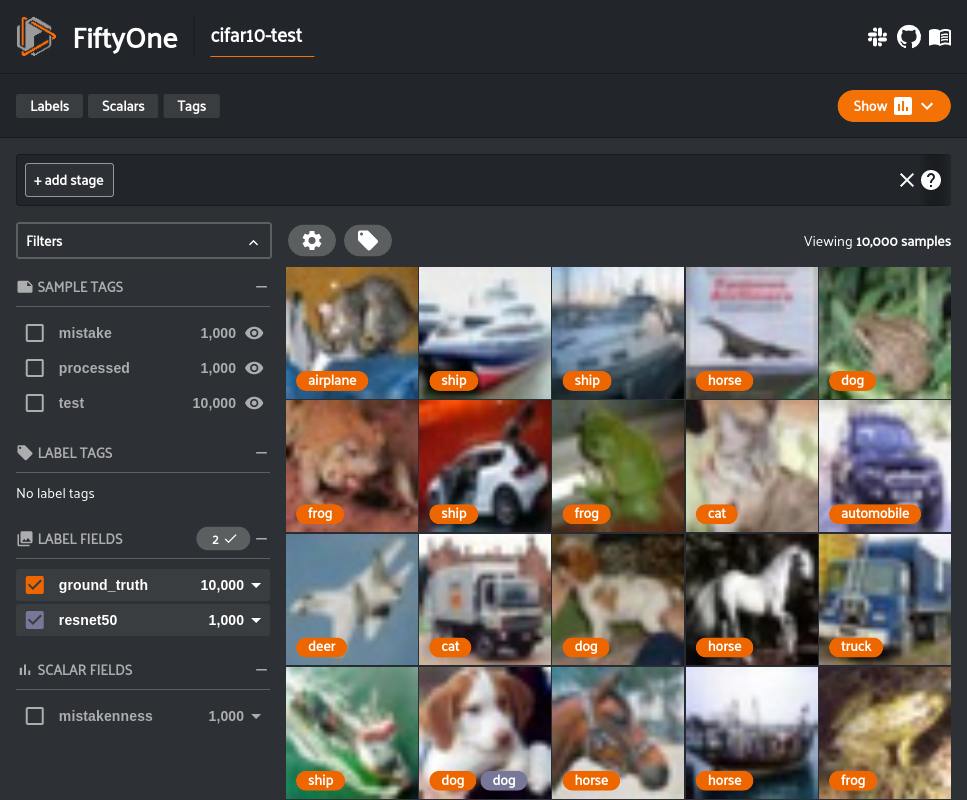

In [9]:
session = fo.launch_app(dataset)


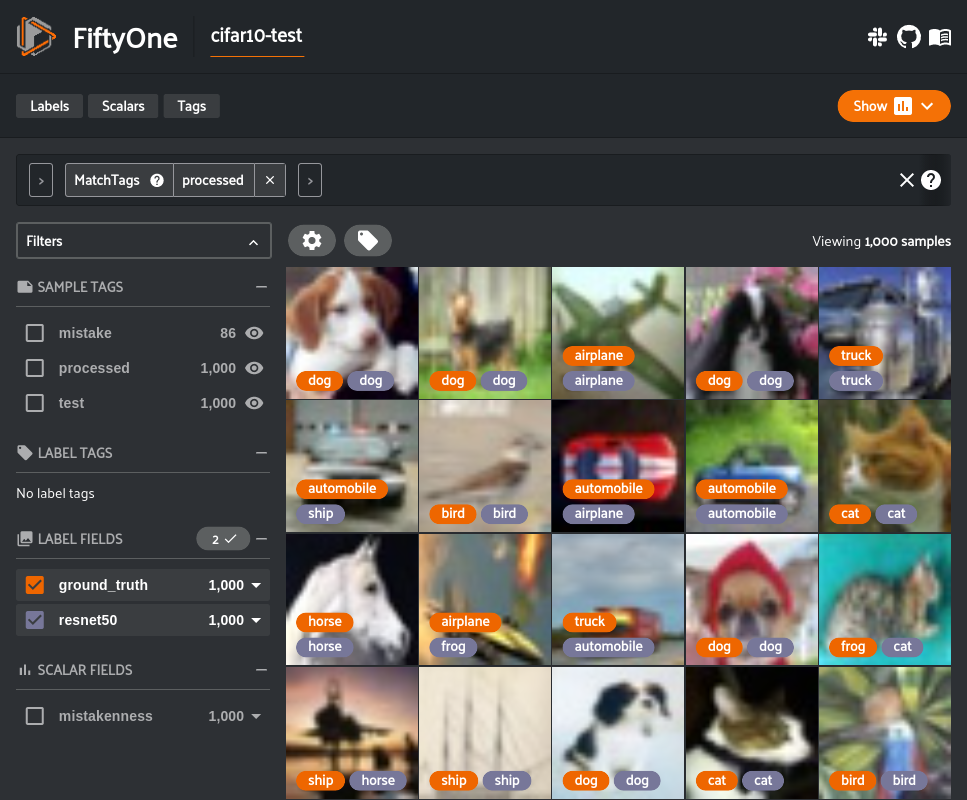

In [10]:
# Show only the samples that were processed
session.view = dataset.match_tags("processed")


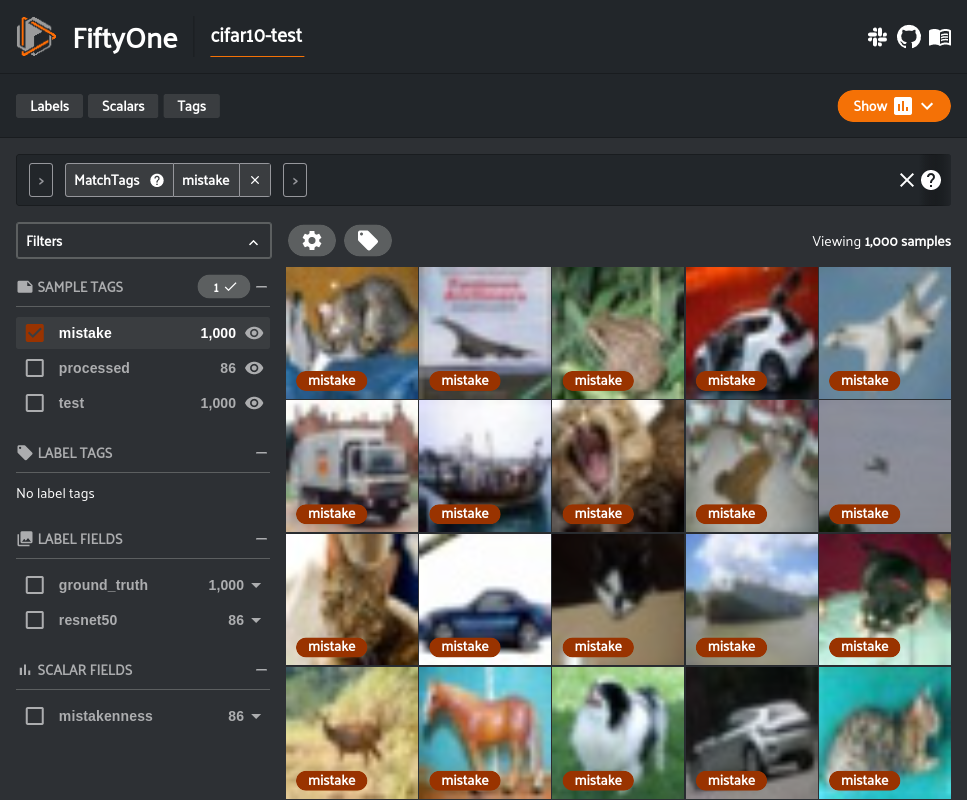

In [15]:
# Show only the samples for which we added label mistakes
session.view = dataset.match_tags("mistake")


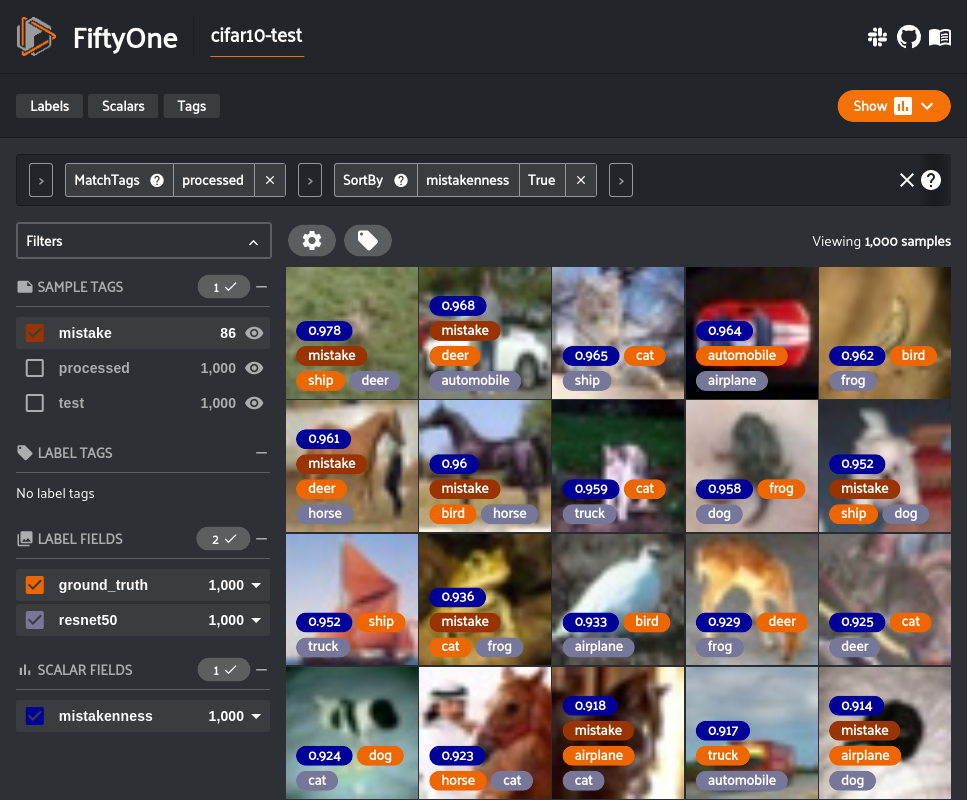

In [18]:
# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

In a real world scenario, we would then take the ground truth classifications that are likely mistakes and send them off to our annotation provider of choice as annotations to be reviewed. FiftyOne currently offers integrations for both [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html) and [Scale](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html).

In [19]:
session.freeze() # screenshot the active App for sharing